# Laboratorio 2 - Series de tiempo

* Mariana David 201055


In [45]:
#importamos las librerías necesarias para trabajar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import statsmodels.api as sm

import datetime

ModuleNotFoundError: No module named 'statsmodels'

Leemos .csv 

In [23]:
import pandas as pd

# Unir los datasets de precios 
precios_2021 = pd.read_csv('Precios_Promedio2021.csv')
precios_2022 = pd.read_csv('Precios_Promedio2022.csv')
precios_2023 = pd.read_csv('Precios_Promedio2023.csv')
importaciones = pd.read_csv("imp_vol.csv")

#Unimos precios
precios_prom = pd.concat([precios_2021, precios_2022, precios_2023])

#Eliminamos datos que no nos sirven
precios_prom.drop(["Bunker", "Tipo de Cambio"], axis=1, inplace=True)


***Análisis exploratorio***

Creamos una función que determina, como vector, las fechas de cada registro en los datos. Luego, se sobreescribe esta columna en el *dataframe*, con el fin de manejarlo más adelante dentro de las gráficas y el estudio de los datos.

In [20]:
def formato_fecha(df):
    fechas = []
    for i in range(0, len(df)):
        fecha = str(datetime.date(int(df["Anio"][i]), int(df["Mes"][i]), 1))
        fechas.append(fecha)
    
    df["Fechas"] = fechas

Para el dataframe **datos importaciones combustibles**, puede observarse que se cuenta con 245 filas y 29 columnas, dentro de las cuales existe una cantidad considerable de datos no disponibles (NaN). En particular, a primera vista esto es evidente para las columnas de "DieselLS", "DieselULS", "Solventes", "Naftas", "Ceras", "Butano", "Orimulsion", "MezclasOleosas" y "PetroleoCrudo".

In [21]:
importaciones

,Fecha,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petróleo,Gasolina de aviación,...,Kerosina,Mezclas oleosas,Naftas,PetCoke,Petróleo crudo,Solventes,Butano,Diesel alto azufre,Orimulsión,Total
0,2000-01-01 00:00:00,0.00,48446.00,296766.99,0.00,0.00,0.00,0.00,194410.476190,1426.00,...,64026.09,0.00,0.00,0.00,0.00,0.00,0.0,634667.06,0,1.750545e+06
1,2000-02-01 00:00:00,0.00,50597.00,328116.44,0.00,0.00,0.00,0.00,174710.552381,1458.00,...,62660.30,0.00,0.00,0.00,0.00,0.00,0.0,642380.66,0,1.773220e+06
2,2000-03-01 00:00:00,0.00,27593.00,368589.63,0.00,0.00,0.00,0.00,189234.066667,1503.00,...,61361.99,0.00,0.00,0.00,0.00,0.00,0.0,699807.25,0,1.909499e+06
3,2000-04-01 00:00:00,0.00,53794.00,396300.47,0.00,0.00,0.00,0.00,174330.607143,1561.00,...,61814.32,0.00,0.00,0.00,0.00,0.00,0.0,586803.98,0,1.800933e+06
4,2000-05-01 00:00:00,0.00,60137.00,449368.92,0.00,0.00,0.00,0.00,191745.147619,1642.00,...,54098.32,0.00,0.00,0.00,0.00,0.00,0.0,656948.20,0,1.941772e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,2023-01-01 00:00:00,26561.43,77035.87,105294.71,-380.72,73581.22,1285932.51,9391.16,574148.000000,1224.04,...,540.21,2222.59,142.63,427535.42,112435.87,7647.92,0.0,0.00,0,4.112994e+06
277,2023-02-01 00:00:00,25743.23,74416.24,116577.42,-287.62,66761.16,1226884.63,8398.95,497273.190000,1134.43,...,935.55,1133.80,145.61,311098.09,100237.67,16166.19,0.0,0.00,0,3.728619e+06
278,2023-03-01 00:00:00,31025.18,69630.40,194492.83,NaN,83431.51,1463008.43,11462.71,588892.160000,1514.78,...,-1882.43,2024.49,268.68,311475.22,112090.14,12781.27,0.0,0.00,0,4.412649e+06
279,2023-04-01 00:00:00,22208.24,74654.67,157844.83,-841.64,80733.64,1248429.37,10553.37,513919.890000,1390.03,...,-1568.78,940.32,108.23,322290.11,96434.73,13410.95,0.0,0.00,0,3.924689e+06


Observación de datos 

In [35]:
#datos contenido
precios_prom.head()


,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.,Unnamed: 7
0,1-ene-21,21.91,21.11,17.61,99.0,3.96
1,2-ene-21,21.91,21.11,17.61,99.0,3.96
2,3-ene-21,21.91,21.11,17.61,99.0,3.96
3,4-ene-21,21.91,21.11,17.61,99.0,3.96
4,5-ene-21,21.91,21.11,17.61,99.0,3.96


In [34]:
#descripion de datos
precios_prom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 948 entries, 0 to 217
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FECHA                948 non-null    object 
 1   Superior             948 non-null    float64
 2   Regular              948 non-null    float64
 3   Diesel               948 non-null    float64
 4   Glp Cilindro 25Lbs.  948 non-null    float64
 5   Unnamed: 7           948 non-null    float64
dtypes: float64(5), object(1)
memory usage: 51.8+ KB


Valoramos las variables cuantitativas

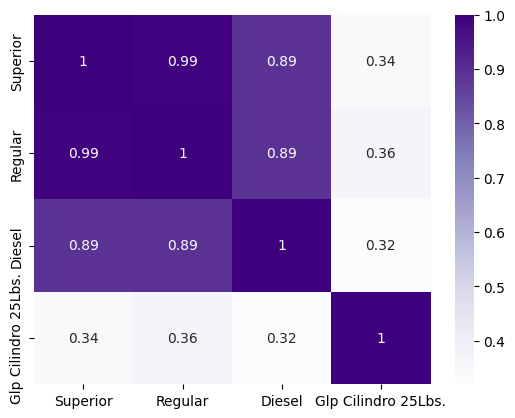

In [48]:
cuantitativas = [
    "Superior",
    "Regular",
    "Diesel",
    "Glp Cilindro 25Lbs."
]

precios_prom_cuantitativas = precios_prom[cuantitativas]
cr = precios_prom_cuantitativas.corr()
sns.heatmap(cr, annot=True, cmap="Purples")
plt.show()


c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable h

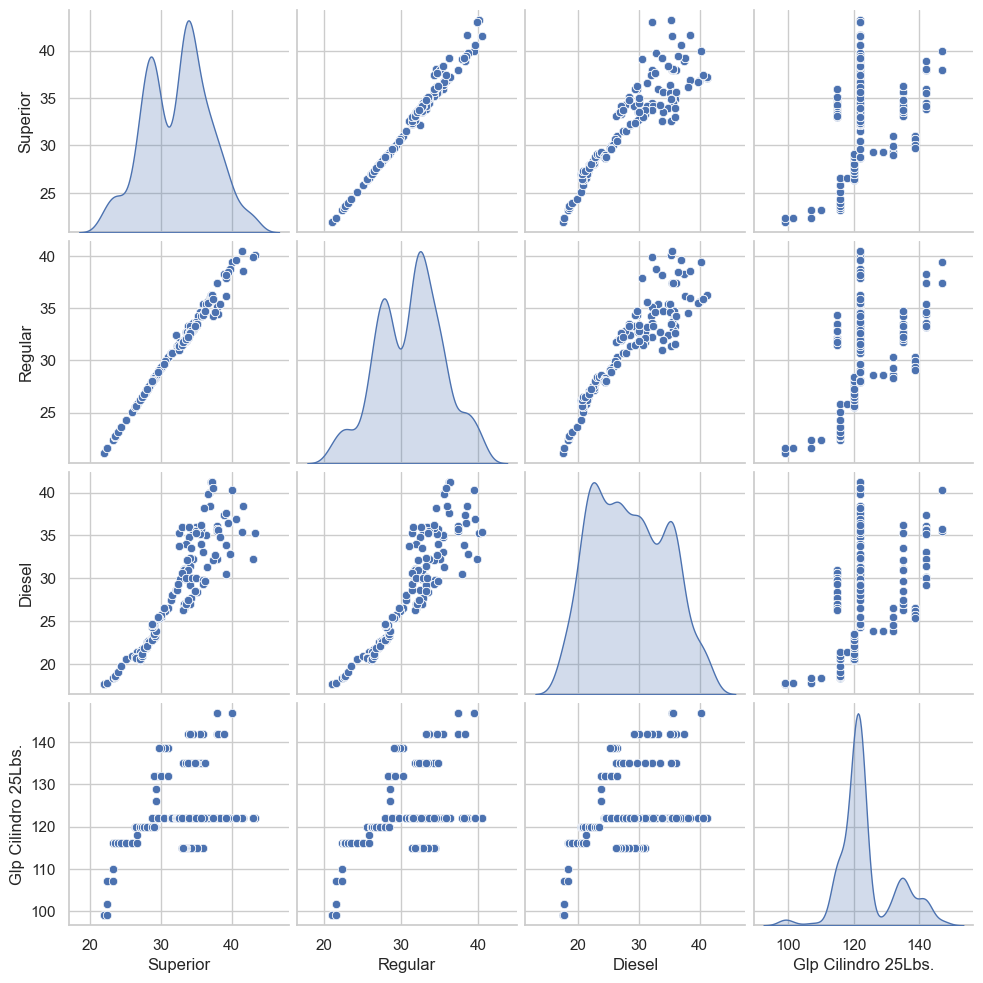

In [52]:
custom_palette = sns.color_palette("RdPu")
sns.set(style="whitegrid")  
grid = sns.pairplot(precios_prom_cuantitativas, diag_kind="kde", palette="plasma")
plt.show()

***Generamos diagrma de caja y bigotes***

2A. Consumo mensual de gasolina super

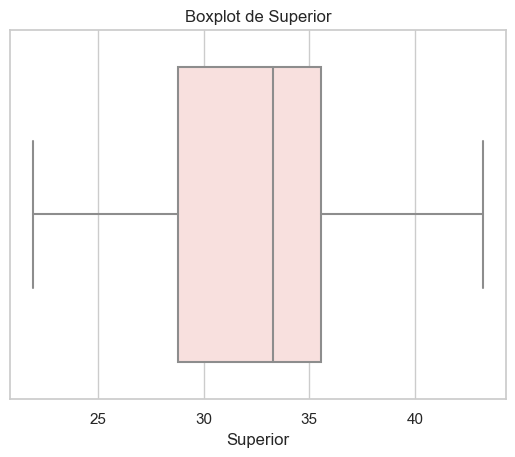

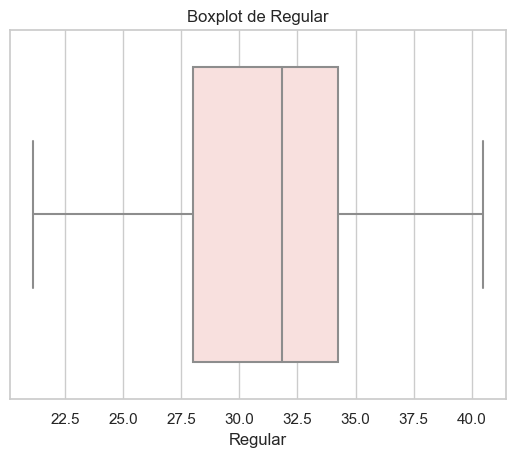

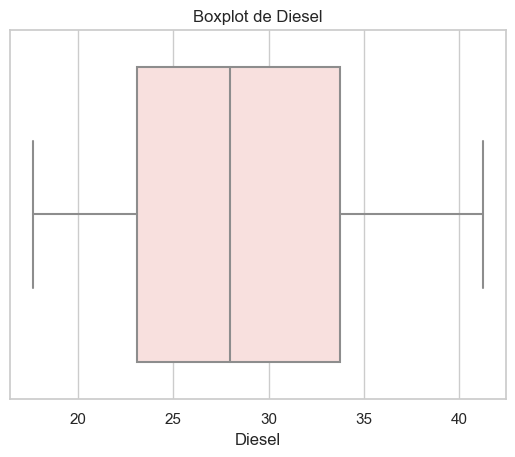

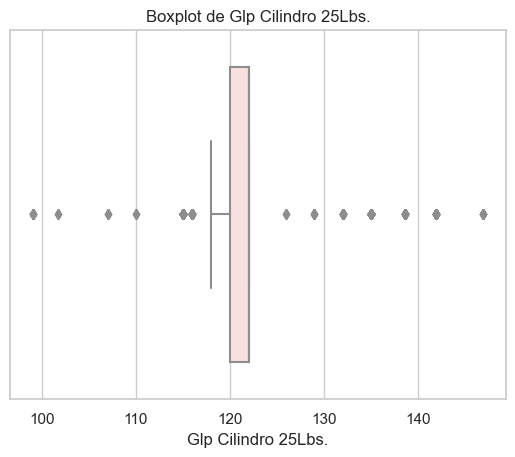

In [54]:
sns.set_style("whitegrid")  # Establece un estilo de trama con fondo blanco y cuadrícula
sns.set_palette("RdPu")      # Establece la paleta de colores en tonos rosados

for col in cuantitativas:
    sns.boxplot(x=precios_prom[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

2B. Importación mensual de gasolina super gasolina regular, diésel y gas licuado


2C. Precios en ciudad capital de gasolina super, gasolina regular, diésel y gas licuado

***De cada serie de las seleccionadas:***

a. Especifique Inicio, fin, y frecuencia.

b. Haga un gráfico de la serie y explique qué información puede obtener a primera vista.

c. Descomponga la serie. Teniendo en cuenta el diagrama de la serie y sus componentes discuta si es posible hablar de estacionariedad en media y en varianza.

d. Determine si es necesario transformar la serie Explique.

e. Explique si no es estacionaria en media. Para esto:
    i. Haga el gráfico de autocorrelación y úselo para explicar la no estacionariedad en media.
    ii. Básese en los valores de estadísticos como la prueba de Dickey-Fuller Aumentada para corroborar la no estacionariedad en media. ¿Qué es necesario hacer para hacerla estacionaria en media en caso de que no lo sea?

f. Una vez analizada la serie, elija los parámetros p, q y d del modelo ARMA o ARIMA que utilizará para predecir. Explique en qué se basó para darle valor a estos parámetros, basándose en las funciones de autocorrelación y autocorrelación parcial. Si usa la función autoarima de R, determine y explique si tiene sentido el modelo propuesto.

g. Haga varios modelos ARIMA, y diga cuál es el mejor de ellos para estimar los datos de la serie. Para esto analice los residuos y las métricas AIC y/ BIC.

h. Haga un modelo usando el algoritmo prophet de Facebook o redes neuronales.
Compárelo con los modelos del inciso anterior. ¿Cuál funcionó mejor?

***Predicción de serie***

Haga una predicción de los valores de la serie para los últimos 3 años. Explique qué tan
buena es su predicción. En el caso de la serie de precios, use los datos de 2023 como
conjunto de prueba

In [62]:
# Cargar los datos históricos de precios (supongamos que está en un archivo CSV llamado 'consumo.csv')
data = pd.read_csv('consumo.csv')
# Convertir la columna 'fecha' a tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha']).dt.date

def count_zeros_per_column(dataframe):
    zero_counts = dataframe.apply(lambda column: (column == 0).sum())
    return zero_counts

# Suponiendo que 'data' es tu DataFrame con los datos de 2020 al 2022
zero_counts = count_zeros_per_column(data)

# Imprimir la cantidad de ceros por columna
print(zero_counts)

Fecha                         0
Aceites lubricantes         228
Asfalto                       0
Bunker                        0
Ceras                       260
Combustible turbo jet        60
Diesel bajo azufre          216
Diesel ultra bajo azufre    216
Gas licuado de petróleo       0
Gasolina de aviación          1
Gasolina regular              0
Gasolina superior             0
Grasas lubricantes          228
Kerosina                      0
Mezclas oleosas             241
Naftas                      228
PetCoke                      49
Petróleo crudo               24
Solventes                   228
Butano                      234
Diesel alto azufre           65
Orimulsión                  253
Total                         0
dtype: int64


In [63]:
# Definir la lista de columnas a eliminar
columns_to_drop = ['Aceites lubricantes', 'Ceras', 'Diesel bajo azufre', 'Diesel ultra bajo azufre',
                   'Grasas lubricantes', 'Mezclas oleosas', 'Naftas', 'Solventes', 'Butano', 'Orimulsión']

# Eliminar las columnas con más de 200 datos faltantes
data.drop(columns=columns_to_drop, inplace=True)

# Llenar las columnas restantes con la media
columns_to_fill = data.columns[data.isnull().sum() > 0]
for col in columns_to_fill:
    col_mean = data[col].mean()
    data[col].fillna(col_mean, inplace=True)
    
# Llenar las columnas con ceros
columns_with_zeros = data.columns[data.eq(0).sum() > 0]
for col in columns_with_zeros:
    data[col].replace(0, data[col].mean(), inplace=True)

In [66]:
# Comprueba si quedan valores nulos en el DataFrame
print(data.isnull().sum())
print(data)


Fecha                      0
Asfalto                    0
Bunker                     0
Combustible turbo jet      0
Gas licuado de petróleo    0
Gasolina de aviación       0
Gasolina regular           0
Gasolina superior          0
Kerosina                   0
PetCoke                    0
Petróleo crudo             0
Diesel alto azufre         0
Total                      0
dtype: int64
          Fecha   Asfalto     Bunker  Combustible turbo jet  \
0    2000-01-01  48446.00  296766.99           35953.793274   
1    2000-02-01  50597.00  328116.44           35953.793274   
2    2000-03-01  27593.00  368589.63           35953.793274   
3    2000-04-01  53794.00  396300.47           35953.793274   
4    2000-05-01  60137.00  449368.92           35953.793274   
..          ...       ...        ...                    ...   
276  2023-01-01  77035.87  105294.71           73581.220000   
277  2023-02-01  74416.24  116577.42           66761.160000   
278  2023-03-01  69630.40  194492.83       

NameError: name 'Sequential' is not defined

***Predicción para año 2023***

Haga una predicción para todo este año 2023 determine qué tan apegada es a la realidad
teniendo en cuenta los meses pasados del año actual

***Discusión***

Discuta cuál fue el comportamiento de las series durante la pandemia. ¿Qué tanto afectó
las predicciones?¿se recuperaron los valores habituales en el regreso a la “nueva
normalidad”?
